In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph

In [3]:
import mne
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from scipy.spatial import Delaunay
import networkx as nx
import scipy.sparse as sp
import scipy.io as spio
import time
from sklearn.neighbors import NearestNeighbors

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage, make_dig_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import Scaler

from torch_geometric.data import Data, InMemoryDataset

In [4]:
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os

In [5]:
DATA_PATH = '../Preprocessed_EEG/'

labels = list(scipy.io.loadmat(DATA_PATH + 'label.mat')['label'][0])
labels

[1, 0, -1, -1, 0, 1, -1, 0, 1, 1, 0, -1, 0, 1, -1]

In [6]:
files = list(filter(lambda x: x[0].isnumeric() and x[-4:] == '.mat', os.listdir(DATA_PATH)))
len(files)

45

In [146]:
channel_order = pd.read_excel("../China_information.xlsx", sheet_name='Channel_name_and_order')
my_channels = channel_order['Channel Name']
ch_series = pd.DataFrame({'ch_names' :make_standard_montage('standard_1020').ch_names}).ch_names

montage_dict = dict()
base_dict = make_standard_montage('standard_1020', head_size=0.08).get_positions()['ch_pos']
for ch_name in ch_series[ch_series.isin(my_channels)].values:
    montage_dict[ch_name] = base_dict[ch_name]
montage_dict['CB1'] = base_dict['O1']
montage_dict['CB2'] = base_dict['O2']

seed_montage = make_dig_montage(ch_pos=montage_dict)

In [8]:
def calc_shannon_entropy(data_set):
    """
        Input : 1 * N vector
        Output: Float with the wavelet entropy of the input vector,
                rounded to 3 decimal places.
    """
    probability = np.square(data_set)
    shannon_entropy = -np.nansum(probability * np.log2(probability))
    return round(shannon_entropy, 3)

In [24]:
values = data_df.iloc[0].values

In [27]:
from scipy.stats import differential_entropy

differential_entropy(values)

4.610997186583874

In [26]:
calc_shannon_entropy(values)

/tmp/ipykernel_385450/1960754445.py:8: RuntimeWarning: divide by zero encountered in log2
  shannon_entropy = -np.nansum(probability * np.log2(probability))
/tmp/ipykernel_385450/1960754445.py:8: RuntimeWarning: invalid value encountered in multiply
  shannon_entropy = -np.nansum(probability * np.log2(probability))


-515206032.13

In [205]:
def get_bands(data, fs=200):
    # data = data[1]
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    res = []
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        res.append(differential_entropy(fft_vals[freq_ix]))

    return res

In [37]:
def get_bands_freq(data, lenght=266, fs=200):
    data = data[1]
    res = []
    for i in range(0, len(data), fs):
        if len(data[i:i+fs]) == fs:
            res.extend(get_bands(data[i:i+fs], fs))
        
    res += [0] * (5 * lenght - len(res))
    return np.array(res)

In [36]:
266 * 5

1330

In [ ]:
max_len = 0
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        max_len = max(data_df.shape[1], max_len)

max_len

In [15]:
53001 / 200

265.005

In [11]:
from multiprocessing import cpu_count, Pool

cpu_count()

12

In [206]:
features_tensor = []
targets = []
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        #sample = np.stack([get_bands(channel[1]) for channel in data_df.iterrows()])
        with Pool(cpu_count()) as p:
            sample = np.stack(p.map(get_bands, data_df.iterrows()))
            p.close()
            p.join()
        features_tensor.append(sample)
    targets.extend(labels)

features_tensor = np.stack(features_tensor)
features_tensor = torch.tensor(features_tensor).float()

targets = torch.tensor(targets) + 1
targets = (torch.tensor([0, 1, 2]) == targets.reshape(-1, 1)).int()

100%|███████████████████████████████████████████| 45/45 [09:27<00:00, 12.60s/it]


In [149]:
features_tensor = []
targets = []
for file in tqdm(files):
    mat_file = spio.loadmat(DATA_PATH + file)
    keys = [key for key, values in mat_file.items() if key != '__header__' and key != '__version__' and key != '__globals__' ]
    for data_file in keys:
        data_df = pd.DataFrame(mat_file[data_file])
        #sample = np.stack([get_bands_freq(channel[1]) for channel in data_df.iterrows()])
        with Pool(cpu_count()) as p:
            sample = np.stack(p.map(get_bands_freq, data_df.iterrows()))
            p.close()
            p.join()
        features_tensor.append(sample)
    targets.extend(labels)

features_tensor = np.stack(features_tensor)
features_tensor = torch.tensor(features_tensor).float()

targets = torch.tensor(targets) + 1
targets = (torch.tensor([0, 1, 2]) == targets.reshape(-1, 1)).int()

100%|███████████████████████████████████████████| 45/45 [17:37<00:00, 23.49s/it]


In [207]:
frac = round(features_tensor.size(0) * 0.2)

train_A_dataset = CNNMatrixDataset(tensors=(features_tensor[:-frac], targets[:-frac]), with_target=True, transform=None)
test_A_dataset = CNNMatrixDataset(tensors=(features_tensor[-frac:], targets[-frac:]), with_target=True, transform=None)

batch_size = 128 #256

train_A_CNN = DataLoader(train_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True
test_A_CNN = DataLoader(test_A_dataset, batch_size=batch_size, shuffle=True) # , shuffle=True

data_loaders_CNN = {'train':train_A_CNN, 'val':test_A_CNN}

In [208]:
import sys
sys.path.append('../src')

from data import GraphMatrixDataset, CNNMatrixDataset
from utils import P300Getter, train_model, plot_sample, show_progress, count_parameters
from interpretation import *
from models_cnn import *
from models_gnn import *
from graph import get_delaunay_graph, get_neighbors_graph

In [209]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 10000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
model_CNN = BaseCNN(5, 62, time_kernel=3, num_classes=3)

loss_cnn, acc_cnn, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=1000)

/home/leonid/Projects/pattern_recognition/notebooks/../src/models_cnn.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


cuda:0
Epoch 999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9966	 Min Acc: 0.4931	 Acc: 0.5352	 Max Acc: 0.5773	
val	 Loss: 1.0040	 Min Acc: 0.4268	 Acc: 0.5111	 Max Acc: 0.5954	
Epoch 1999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9531	 Min Acc: 0.5286	 Acc: 0.5704	 Max Acc: 0.6121	
val	 Loss: 0.9856	 Min Acc: 0.4268	 Acc: 0.5111	 Max Acc: 0.5954	
Epoch 2999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9259	 Min Acc: 0.5927	 Acc: 0.6333	 Max Acc: 0.6740	
val	 Loss: 0.9750	 Min Acc: 0.4642	 Acc: 0.5481	 Max Acc: 0.6321	
Epoch 3999/9999
---------------------------------------------------------------------------

In [210]:
count_parameters(model_CNN)

87

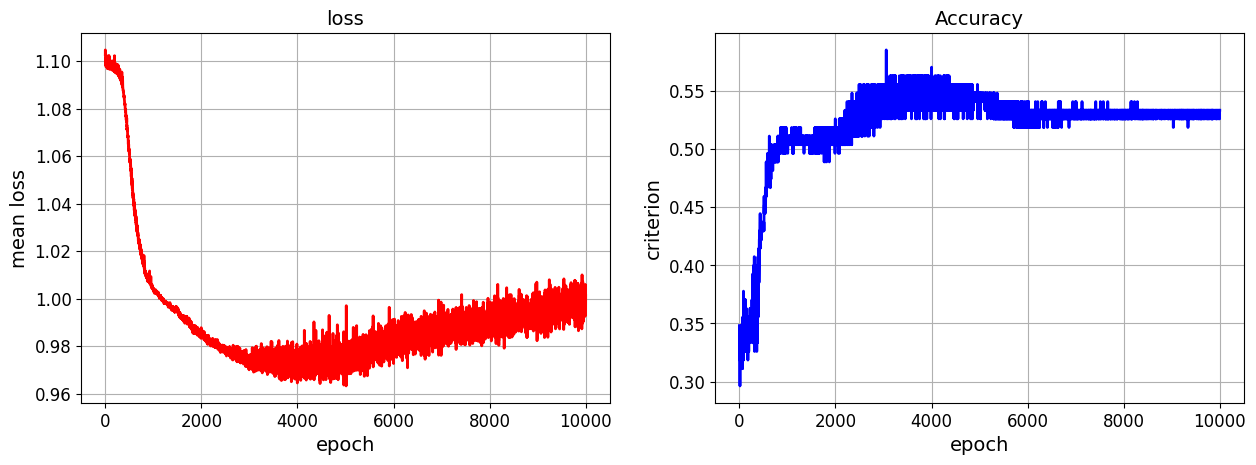

In [211]:
show_progress(loss_cnn, acc_cnn, 'loss', 'Accuracy')

In [213]:
max(acc_cnn['Accuracy'])

0.5851851851851853

In [214]:
t = np.argmax(acc_cnn['Accuracy'])
acc_cnn['Min Accuracy'][t], acc_cnn['Max Accuracy'][t]

(0.5020748569665603, 0.66829551340381)

In [215]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 10000,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
model_GNN = BaseGNN(5, 62, A, time_kernel=3, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=1000)

cuda:0
Epoch 999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9958	 Min Acc: 0.4782	 Acc: 0.5204	 Max Acc: 0.5625	
val	 Loss: 0.9741	 Min Acc: 0.4268	 Acc: 0.5111	 Max Acc: 0.5954	
Epoch 1999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9718	 Min Acc: 0.5230	 Acc: 0.5648	 Max Acc: 0.6066	
val	 Loss: 0.9662	 Min Acc: 0.4342	 Acc: 0.5185	 Max Acc: 0.6028	
Epoch 2999/9999
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.9559	 Min Acc: 0.5606	 Acc: 0.6019	 Max Acc: 0.6431	
val	 Loss: 0.9710	 Min Acc: 0.4417	 Acc: 0.5259	 Max Acc: 0.6102	
Epoch 3999/9999
---------------------------------------------------------------------------

In [216]:
count_parameters(model_GNN)

241

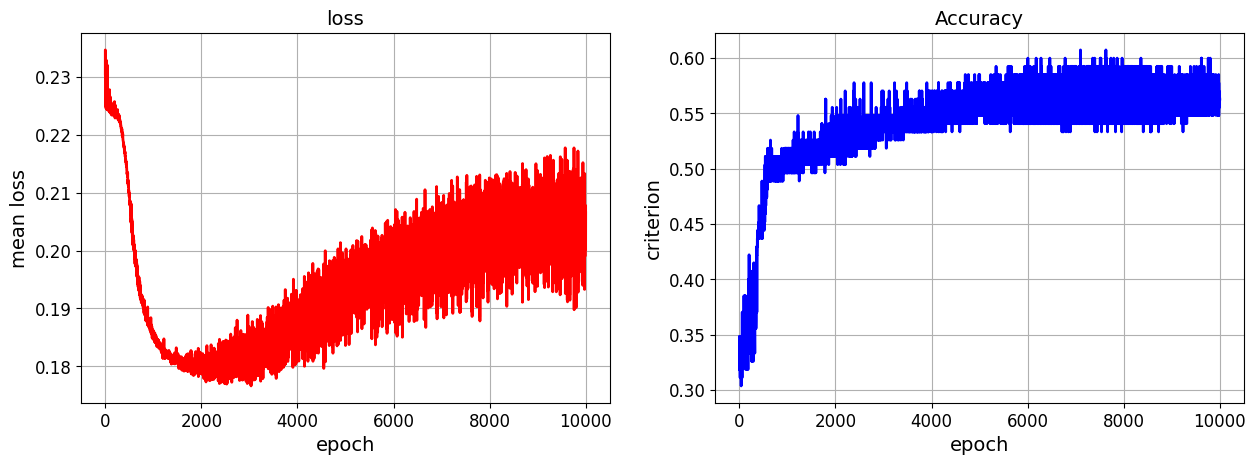

In [217]:
show_progress(loss, acc, 'loss', 'Accuracy')

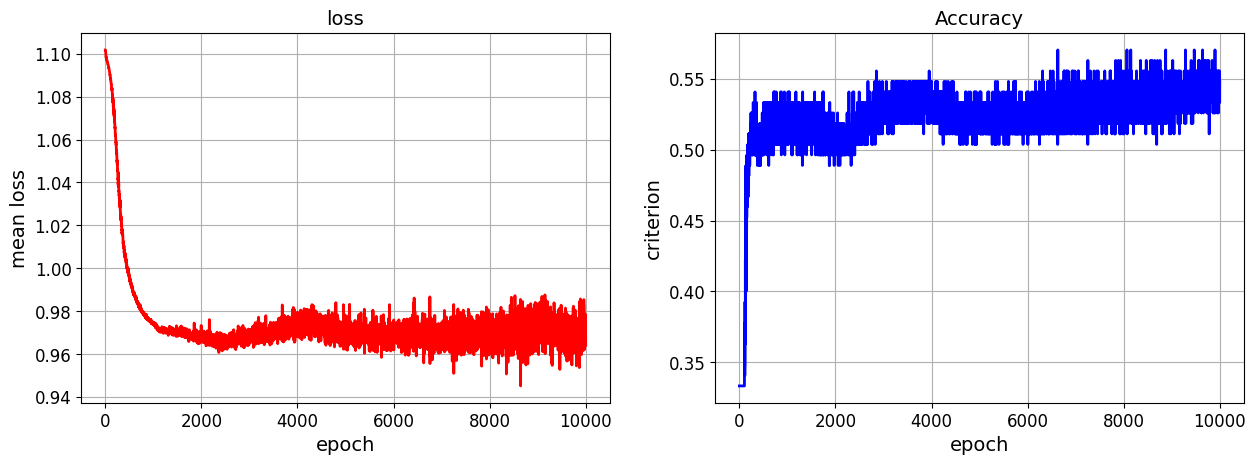

In [218]:
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [219]:
max(acc_gnn['Accuracy'])

0.5703703703703704

In [220]:
t = np.argmax(acc_gnn['Accuracy'])
acc_gnn['Min Accuracy'][t], acc_gnn['Max Accuracy'][t]

(0.4868664630211451, 0.6538742777195957)

In [96]:
for name, param in model_CNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

linear_channel.weight 62
linear_channel.bias 1
conv.weight 3
conv.bias 1
bn1.weight 1
bn1.bias 1
linear_output.weight 15
linear_output.bias 3


In [97]:
for name, param in model_GNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

gc.h.weight 25
gc.h.bias 5
linear_channel.weight 62
linear_channel.bias 1
conv.weight 3
conv.bias 1
bn1.weight 62
bn1.bias 62
bn2.weight 1
bn2.bias 1
linear_output.weight 15
linear_output.bias 3


/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


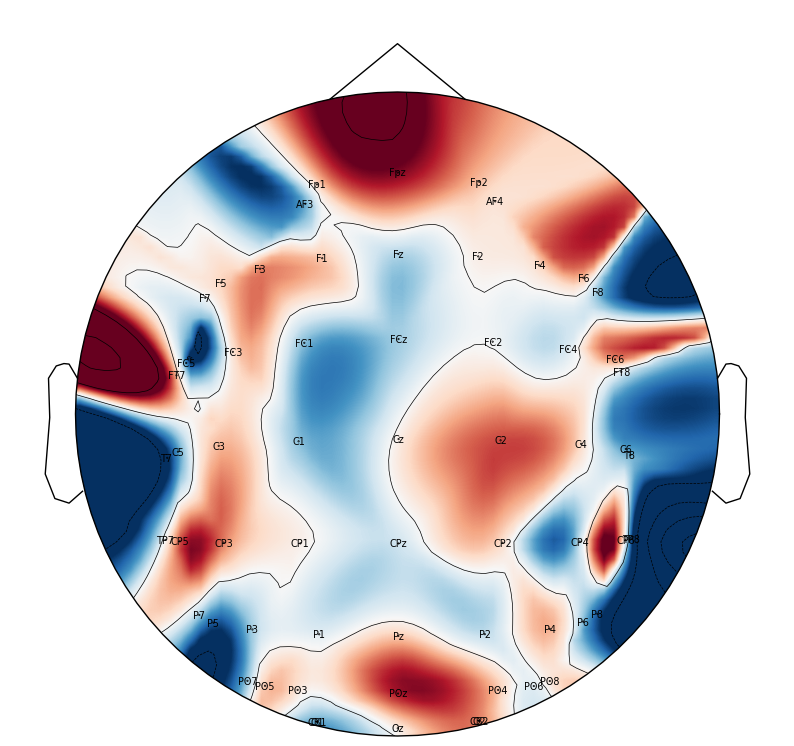

In [145]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

cuda:0


/home/leonid/Projects/pattern_recognition/notebooks/../src/models_cnn.py:158: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.7718	 Min Acc: 0.8747	 Acc: 0.9000	 Max Acc: 0.9253	
val	 Loss: 0.8597	 Min Acc: 0.6749	 Acc: 0.7481	 Max Acc: 0.8214	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6245	 Min Acc: 0.9750	 Acc: 0.9852	 Max Acc: 0.9954	
val	 Loss: 0.7543	 Min Acc: 0.7409	 Acc: 0.8074	 Max Acc: 0.8739	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5847	 Min Acc: 0.9854	 Acc: 0.9926	 Max Acc: 0.9998	
val	 Loss: 0.7293	 Min Acc: 0.7662	 Acc: 0.8296	 Max Acc: 0.8930	
Epoch 399/499
------------------------------------------------------------------------------------------

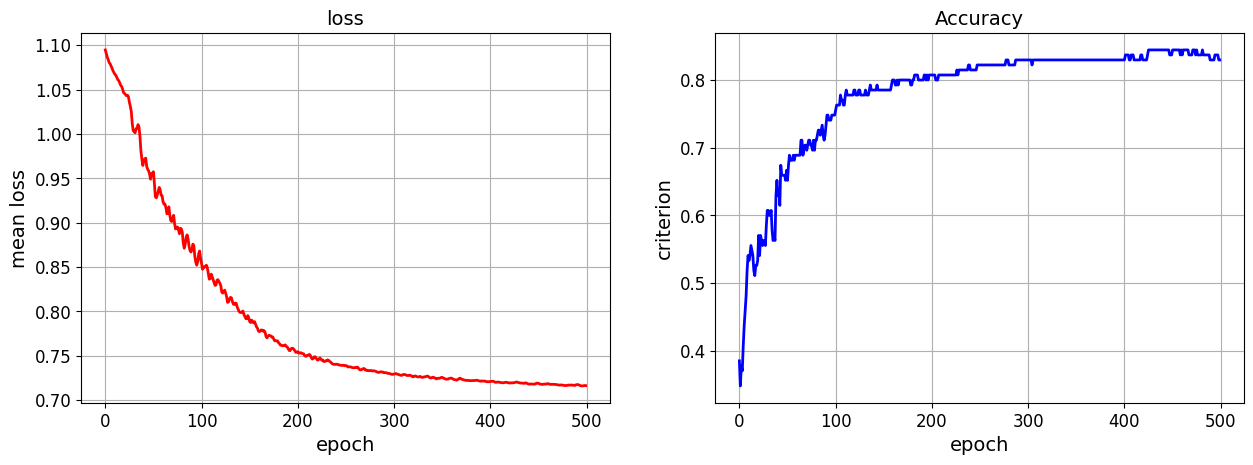

In [186]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model_CNN = BaseCNN(1330, 62, time_kernel=5, num_classes=3)

loss_cnn, acc_cnn, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_cnn, acc_cnn, 'loss', 'Accuracy')

In [187]:
count_parameters(model_CNN)

4064

In [188]:
max(acc_cnn['Accuracy'])

0.8444444444444444

In [189]:
acc_cnn['Min Accuracy'][381], acc_cnn['Max Accuracy'][381]

(0.7662104868297802, 0.893048772429479)

cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6554	 Min Acc: 0.8934	 Acc: 0.9167	 Max Acc: 0.9400	
val	 Loss: 0.6967	 Min Acc: 0.8093	 Acc: 0.8667	 Max Acc: 0.9240	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5555	 Min Acc: 0.9945	 Acc: 0.9981	 Max Acc: 1.0000	
val	 Loss: 0.6312	 Min Acc: 0.9009	 Acc: 0.9407	 Max Acc: 0.9806	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5540	 Min Acc: 0.9945	 Acc: 0.9981	 Max Acc: 1.0000	
val	 Loss: 0.6233	 Min Acc: 0.9009	 Acc: 0.9407	 Max Acc: 0.9806	
Epoch 399/499
-----------------------------------------------------------------------------------

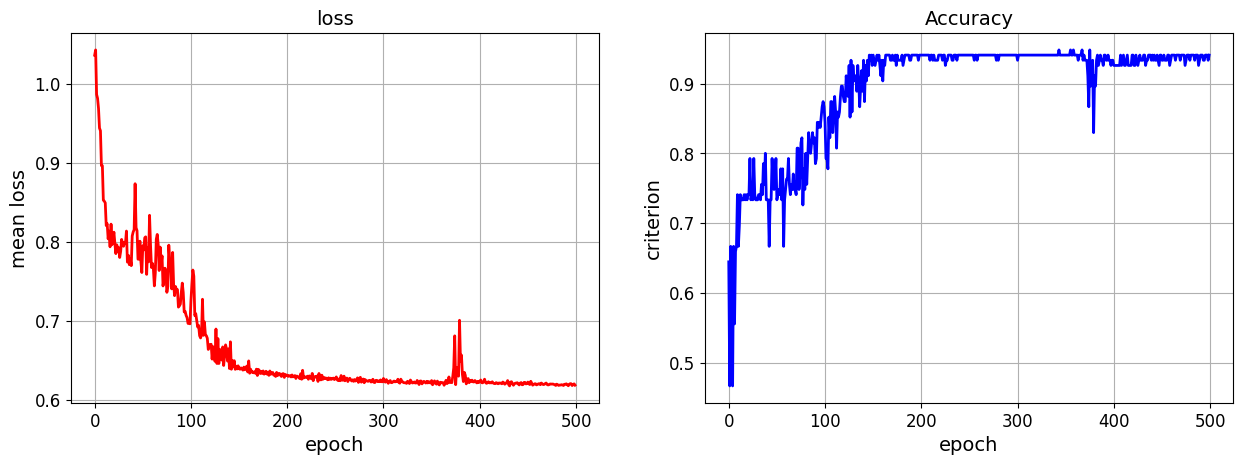

In [190]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_delaunay_graph(seed_montage).toarray()).to(my_device)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [191]:
count_parameters(model_GNN)

1774418

In [192]:
max(acc_gnn['Accuracy'])

0.9481481481481482

In [193]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.9107455782598419, 0.9855507180364544)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


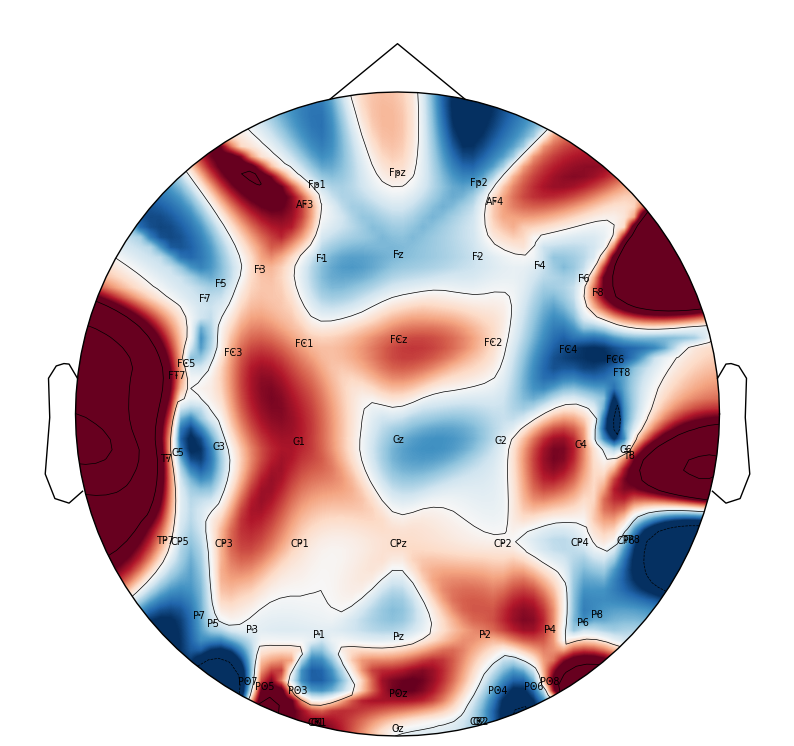

In [194]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

In [78]:
for name, param in model_CNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

linear_channel.weight 62
linear_channel.bias 1
conv.weight 3
conv.bias 1
bn1.weight 1
bn1.bias 1
linear_output.weight 3990
linear_output.bias 3


In [77]:
for name, param in model_GNN.named_parameters():
    if param.requires_grad:
        print(name, param.data.numel())

gc.h.weight 1768900
gc.h.bias 1330
linear_channel.weight 62
linear_channel.bias 1
conv.weight 5
conv.bias 1
bn2.weight 1
bn2.bias 1
linear_output.weight 3990
linear_output.bias 3


cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6041	 Min Acc: 0.9630	 Acc: 0.9759	 Max Acc: 0.9889	
val	 Loss: 0.6880	 Min Acc: 0.8093	 Acc: 0.8667	 Max Acc: 0.9240	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5532	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6611	 Min Acc: 0.8449	 Acc: 0.8963	 Max Acc: 0.9477	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5521	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6582	 Min Acc: 0.8449	 Acc: 0.8963	 Max Acc: 0.9477	
Epoch 399/499
-----------------------------------------------------------------------------------

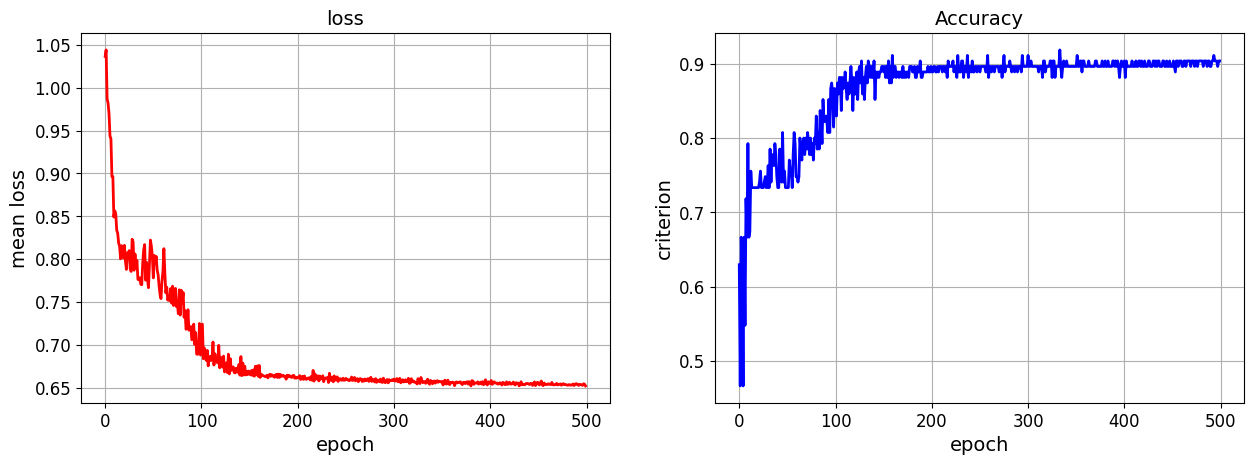

In [195]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

A = torch.tensor(get_neighbors_graph(seed_montage).toarray()).to(my_device)
model_GNN = BaseGNN(1330, 62, A, time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [196]:
count_parameters(model_GNN)

1774418

In [197]:
max(acc_gnn['Accuracy'])

0.9185185185185185

In [198]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.8539415658771258, 0.9534658415302816)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


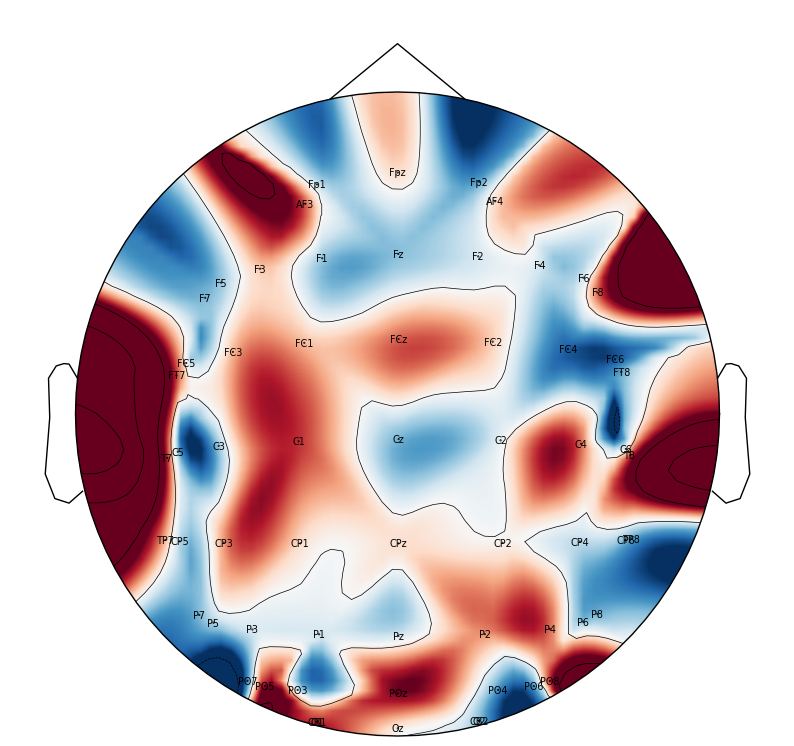

In [199]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()

cuda:0


/home/leonid/Projects/pattern_recognition/notebooks/../src/models_cnn.py:220: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.sig(self.linear_output(x))


Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.8231	 Min Acc: 0.6902	 Acc: 0.7278	 Max Acc: 0.7653	
val	 Loss: 0.8118	 Min Acc: 0.6427	 Acc: 0.7185	 Max Acc: 0.7944	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.7350	 Min Acc: 0.7840	 Acc: 0.8167	 Max Acc: 0.8493	
val	 Loss: 0.7860	 Min Acc: 0.6912	 Acc: 0.7630	 Max Acc: 0.8347	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.6885	 Min Acc: 0.8299	 Acc: 0.8593	 Max Acc: 0.8886	
val	 Loss: 0.7815	 Min Acc: 0.7076	 Acc: 0.7778	 Max Acc: 0.8479	
Epoch 399/499
------------------------------------------------------------------------------------------

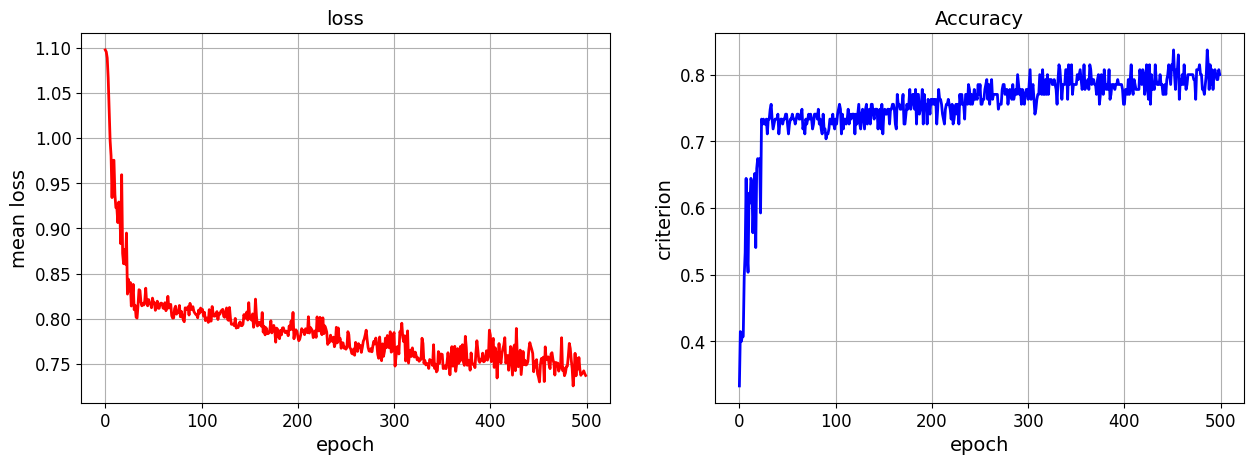

In [200]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

model_CNN = BaseCNNAttn(1330, 62, num_classes=3)

loss_cnn, acc_cnn, total_time = train_model(model_CNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_cnn, acc_cnn, 'loss', 'Accuracy')

In [201]:
count_parameters(model_CNN)

5314754

In [202]:
max(acc_cnn['Accuracy'])

0.837037037037037

In [203]:
acc_cnn['Min Accuracy'][381], acc_cnn['Max Accuracy'][381]

(0.7076479592372036, 0.847907596318352)

cuda:0
Epoch 99/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5794	 Min Acc: 0.9854	 Acc: 0.9926	 Max Acc: 0.9998	
val	 Loss: 0.6691	 Min Acc: 0.8359	 Acc: 0.8889	 Max Acc: 0.9419	
Epoch 199/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5529	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6649	 Min Acc: 0.8270	 Acc: 0.8815	 Max Acc: 0.9360	
Epoch 299/499
------------------------------------------------------------------------------------------------------------------------------------------------------
train	 Loss: 0.5520	 Min Acc: 1.0000	 Acc: 1.0000	 Max Acc: 1.0000	
val	 Loss: 0.6637	 Min Acc: 0.8270	 Acc: 0.8815	 Max Acc: 0.9360	
Epoch 399/499
-----------------------------------------------------------------------------------

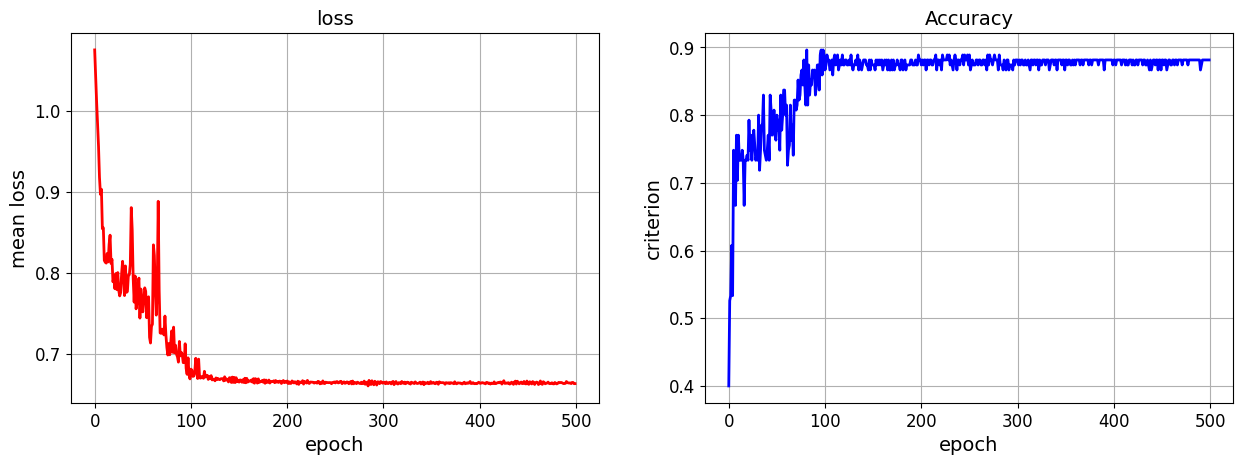

In [180]:
criterion = nn.CrossEntropyLoss()# nn.BCEWithLogitsLoss(pos_weight=torch.tensor(3))# weight=torch.tensor([1, 4], device=my_device)

learning_params = {
    'num_epochs' : 500,
    'lr' : 1e-4,
    'weight_decay' : 1e-2,
    'step_size' : 5,
    'gamma' : 1,
    'num_classes' : 2,
    'model_type' : 'CNN'
  }

torch.manual_seed(44)
np.random.seed(44)

my_device = torch.device('cuda:0')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(my_device)

n_channels = 62
B = torch.bernoulli(torch.zeros(n_channels, n_channels) + 0.5)
i, j = torch.triu_indices(n_channels, n_channels)
B[i, j] = B.T[i, j]
k = torch.arange(n_channels)
B[k, k] = 0

model_GNN = BaseGNN(1330, 62, B.to(my_device), time_kernel=5, num_classes=3)

loss_gnn, acc_gnn, total_time = train_model(model_GNN, data_loaders_CNN, criterion, learning_params, is_binary=False, device=my_device, log_rate=100)
show_progress(loss_gnn, acc_gnn, 'loss', 'Accuracy')

In [181]:
count_parameters(model_GNN)

1774418

In [182]:
max(acc_gnn['Accuracy'])

0.8962962962962964

In [183]:
acc_gnn['Min Accuracy'][355], acc_gnn['Max Accuracy'][355]

(0.8181095386889229, 0.9300386094592253)

/home/leonid/.cache/pypoetry/virtualenvs/pattern-recognition-c2sUhGwq-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


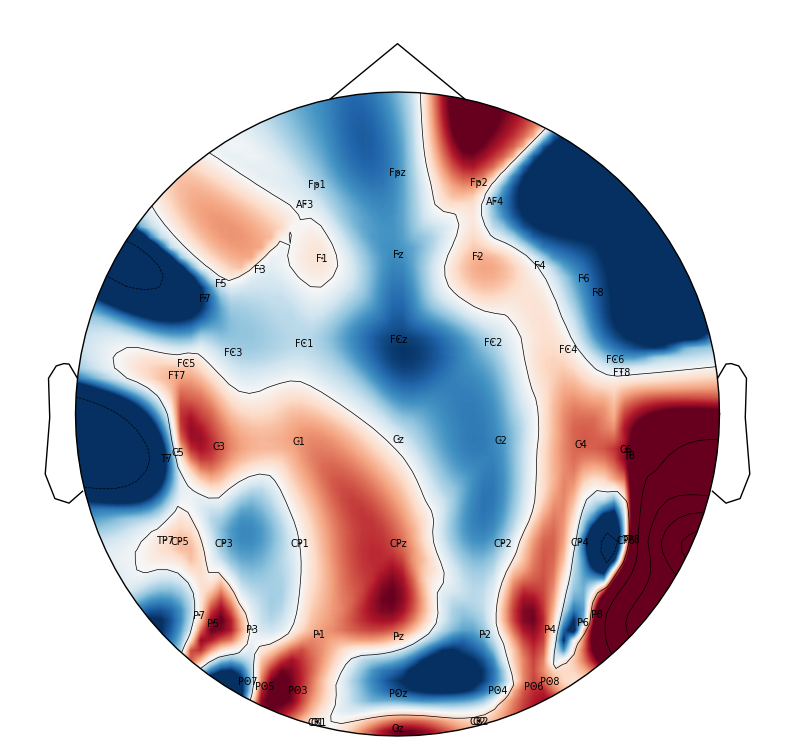

In [184]:
channel_weights = np.array(model_GNN.linear_channel.weight.flatten().detach().cpu())
mne.viz.plot_topomap(channel_weights, np.stack(seed_montage.get_positions()['ch_pos'].values())[:,:-1], size=10, 
                     names=seed_montage.ch_names) #, vmin=min(channel_weights), vmax=max(channel_weights)
plt.show()